In [48]:
import os
import torch
import torchvision
import numpy as np
#import tarfile
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.datasets.utils import download_url
#from torchvision.datasets import CIFAR100
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from PIL import Image, ImageEnhance
import nibabel as nib
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [49]:
file = './ISLES/TRAINING/case_1/SMIR.Brain.XX.O.CT.345562/SMIR.Brain.XX.O.CT.345562.nii'

In [50]:
img = nib.load(file)

In [51]:
img.shape

(256, 256, 8)

(256, 256, 8)
[[-23. -23. -23. ... -23. -23. -23.]
 [-23. -23. -23. ... -23. -23. -23.]
 [-23. -23. -23. ... -23. -23. -23.]
 ...
 [-23. -23. -23. ... -23. -23. -23.]
 [-23. -23. -23. ... -23. -23. -23.]
 [-23. -23. -23. ... -23. -23. -23.]]
-23.0 2223.0


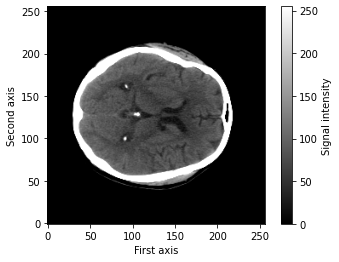

In [72]:
img_data = img.get_fdata()
print(img_data.shape)

section = img_data[:,:,4]
print(section)

section.shape

min=np.min(section)        # result=-23.0
max=np.max(section)        # result=2213.0
print(min,max)


alpha = 2.0 # Simple contrast control
beta = 1.0    # Simple brightness control

for y in range(section.shape[0]):
    for x in range(section.shape[1]):
            section[y,x] = np.clip(alpha*section[y,x] + beta, 0, 255)


plt.imshow(section, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()